# Unsupervised Classification of Hyperspectral Images using Latent Dirichlet Allocation

## Latent Dirichlet Allocation (LDA)

[Latent Dirichlet Allocation](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA) is a type of probabilistic [topic model](http://en.wikipedia.org/wiki/Topic_model) commonly used in natural language processing to extract topics from large collections of documents in an unsupervised manner. LDA assumes that each document in a corpus (collection of documents) is associated with a mixture of topics and the proportions of the topics varies per document. Each topic is represented as a probability distribution over a vocabulary (the set of all allowable words).

The basic generative model for LDA is depicted in [plate notation](http://en.wikipedia.org/wiki/Plate_notation) below (note the boxes (plates) in the figure below indicate iteration over the variable shown in its lower right corner).

<img src="/images/lda_graph_model.svg" width=600/>

The parameter $\boldsymbol{\alpha}$ represents the vector of parameters of the Dirichlet distribution, which affects how topics will be proportioned in a document. $\boldsymbol{\beta}$ is a topic-word matrix, whose columns represent word frequencies associated with a paricular topic ($\boldsymbol{\beta}$ has a column for each topic and each columns sums to 1).

Given $\boldsymbol{\alpha}$ and $\boldsymbol{\beta}$, the LDA model assumes a corpus is generated as follows:

- For each of the $M$ documents in the corpus, sample the Dirichlet distribution (parameterized by $\boldsymbol{\alpha}$) once to produce a topic mixture ($\boldsymbol{\theta}$) for the document.

- For each of the $N$ words in a document, sample the document's multinomial topic distribution (parameterized by $\boldsymbol{\theta}$) to select a topic ($z$) associated with that word. To generate a value for the word, sample the multinomial distribution defined by the column of $\boldsymbol{\beta}$ that corresponds to topic $z$.

The LDA topic model is considered a "bag of words" model for text documents because it does not consider the order of words within documents (e.g., the documents "man bites dog", "dog bites man", and "dog man bites" are all equivalent).

## Mapping Text Topic Models to Hyperspectral Imagery (HSI)

There are numerous ways we could map topic modeling concepts to hyperspectral imagery (HSI). Here, we will use a very simple mapping, as shown in the table below.

<table style="width:700px">
<tr>
  <th>Term</th>
  <th>Text Meaning</th>
  <th>HSI Meaning</th>
</tr>
<tr>
  <td>Corpus</td>
  <td>collection of documents</td>
  <td>image</td>
</tr>
<tr>
  <td>Document</td>
  <td>group of words</td>
  <td>pixel</td>
</tr>
<tr>
  <td>Word</td>
  <td>written word</td>
  <td>spectral feature</td>
</tr>
<tr>
  <td>Vocabulary</td>
  <td>set of all unique words in the corpus</td>
  <td>set of all possible spectral features in the image</td>
</tr>
<tr>
  <td>Topic</td>
  <td>a frequency distribution of words</td>
  <td>a frequency distribution of spectral features</td>
</tr>
</table>

The term "spectral feature" requires explanation. For each spectral band in the image, we will quantize the pixel intensity into $N$ discrete levels. So for an image with $B$ spectral bands, the size of the vocabulary with be $BN$ and each document (pixel) will have exactly $B$ words. It is important to note that this violates one of the assumptions of the LDA bag-of-words model. In LDA, the probability of occurrence of each word is conditionally independent of every other word, given the topic ($\beta$). Letting $w_{i,j}$ denote the word associated with spectral band $i$ at level $j$, we can write this conditional independence as

$$ P \left(w_{i,j} \mid w_{i,k}, \beta \right) = P \left(w_{i,j} \mid \beta \right) , \ \ \ j \ne k $$

However, in the spectral feature word representation described above, only one feature can be present in a document (pixel) for each band. Therefore, in our representation

$$ P \left(w_{i,j} \mid w_{i,k}, \beta \right) = \delta_{jk} P \left(w_{i,j} \mid \beta \right) $$

where $\delta_{ij}$ is the [Kronecker delta](http://en.wikipedia.org/wiki/Kronecker_delta). Furthermore, since hyperspectral images have narrow, contiguous spectral bands, the associated pixel spectra tend to appear continuous. So given the sets of features $w_{i,j}$ and $w_{i+1,k}$ associated with adjacent bands, the conditional probabilities will tend to be higher for small values of $\mid k-j \mid$ and the conditional probabilities will tend to be lower when this quantity is higher.

Notwithstanding this invalid assumption, we will apply the spectral topic model described above to a hyperspectral image and evaluate the results.

## Setting up the HSI Topic Model

The image chip we will use for topic modeling is shown below.

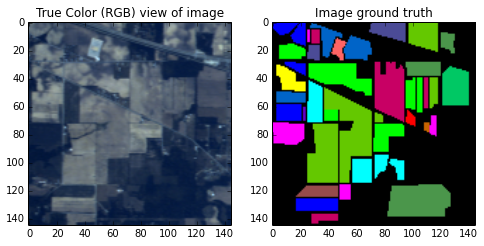

In [1]:
%matplotlib  inline
import matplotlib.pyplot as plt
import numpy as np
import spectral as spy
spy.settings.show_progress = False

image = spy.open_image('92AV3C.lan')
data = image.load()
image.bands = spy.aviris.read_aviris_bands('92AV3C.spc')
gt = spy.open_image('92AV3GT.GIS').read_band(0)

fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
v = spy.imshow(image, bands=(30, 20, 10), fignum=fig.number)
plt.title('True Color (RGB) view of image')
plt.subplot(1, 2, 2)
v = spy.imshow(classes=gt, fignum=fig.number)
plt.title('Image ground truth');

This image is a well-studied $145 \times 145$ pixel [AVIRIS](http://aviris.jpl.nasa.gov/) image chip [1], which contains 220 spectral bands. The left image in the figure shows a "true color" (RGB) view of the chip. The right image depicts ground truth masks for 16 distinct land-use classes, which are mostly associated with agricultural activities.

For this example, we will use 10 quantization levels for each band.

In [2]:
from hsi_topic_models import QuantizedReflectanceLDAModel
nlevels = 10
model = QuantizedReflectanceLDAModel(nlevels)
model.create_corpus(data)

Since our image chip is 145x145 pixels, there are a total of 21,025 documents in the corpus. For 220 bands in the image and 10 levels per band, the resulting vocabulary consists of 2,200 words. Each document is represented by the word counts for each word in the spectral feature vocabulary. Therefore, after creating the image corpus, we should have 21,025 documents, each containing the associated counts for each of the 2,200 words (220 bands times 10 features per band) in the vocabulary.

In [3]:
print model.corpus.shape

(21025, 2200)


Before attempting to learn the LDA model parameters, let's look at how the image topic model transforms the spectral data.

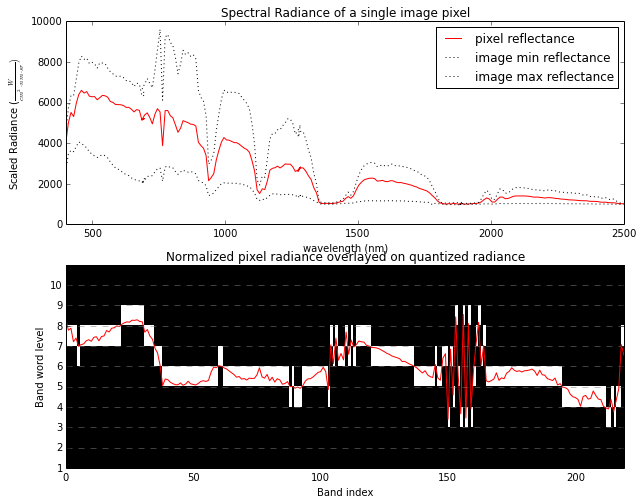

In [4]:
(r, c) = (20, 50)
fig = plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
bands = image.bands.centers
plt.plot(bands, data[r, c], 'r-', zorder=1, label='pixel reflectance')
plt.plot(bands, model.lbound, 'k:', zorder=1, label='image min reflectance')
plt.plot(bands, model.ubound, 'k:', zorder=1, label='image max reflectance')
plt.xlim(bands[0], bands[-1])
plt.ylim(ymin=0)
plt.xlabel('wavelength (nm)')
plt.ylabel(r'Scaled Radiance ($\frac{W}{cm^{2} \cdot nm \cdot sr})$')
plt.legend(loc='best')
plt.title('Spectral Radiance of a single image pixel')
plt.subplot(2, 1, 2)
model.plot_normalized_spectrum(data[r, c], 'r-')
model.show_document_image(r, c, grid=True)
plt.title('Normalized pixel radiance overlayed on quantized radiance');

In the figure above, the top plot shows the scaled radiance of a single image pixel for each spectral band. The radiance spectrum is plotted along with the min/max spectrum calculated from all pixels in the image. The lower plot shows the normalized spectrum (red) of the same pixel, which is computed by subtracting the min spectrum and dividing by the difference between the min and max spectra. The narrow white blocks in the lower plot indicate to which of the 10 spectral words the pixel is assigned for the associated spectral band. The two plots share the same x-axis (the top plot is labeled by band center wavelength, whereas the lower is labeled by band index).

Note that in the quantized spectrum above, there are rapid fluctuations beginning near 1300 and 1800 nm. This is due to absorption by atmospheric water vapor. It would be reasonable to remove these bands prior to applying the topic model to reduce processing time; however, we will retain them nevertheless.

## Learning the LDA Model Parameters

Now that we have constructed the corpus from the image, we will next estimate the document-topic distributions ($\boldsymbol{\theta}$) and the topic-word distributions ($\boldsymbol{\beta}$).

To estimate the LDA parameters, we will use the relatively new [horizont](https://github.com/ariddell/horizont) python package, which fits LDA models using a Markov Chain Monte Carlo (MCMC) method. While it is currently not the fastest LDA implementation available, I've chosen it because it is Open Source, written in Python, has an intuitive interface, and the developer has indicated that he plans to implement a number of additional topic models (which I plan to use).

Although the ground truth image labels 16 ground cover classes, we will start by attempting to learn 5 topics, which should yield classes more general than those in the ground truth image.

In [5]:
from horizont import LDA

# Suppress lots of progress messages
import logging
hlog = logging.getLogger('horizont')
hlog.setLevel(logging.WARNING)

ntopics = 5   # number of topics to generate
niters = 2    # number of MCMC iterations to perform
alpha = 3.0   # Dirichlet prior for topic mixtures
eta = 3.0     # Dirichlet prior for topic-word distributions

lda = LDA(ntopics, niters, alpha, eta)
ret = lda.fit_transform(model.corpus)
model.get_results(lda)

The call to `model.get_results` above takes the output of the LDA model and restructures the data back into arrays corresponding to the image's dimensions.

## Results

First, let's examine how the 5 topics are distributed over the image. Rather than considering the distribution of topics for each document (pixel) individually, we will look at the fractional abundance of each topic over the entire image (i.e., the first image will be the fractional abundance of topic 1 over the entire image). For each topic, we will plot a fractional abundance image (left), as well as a topic-word image (right), which depicts the distribution of spectral features for the associated topic.

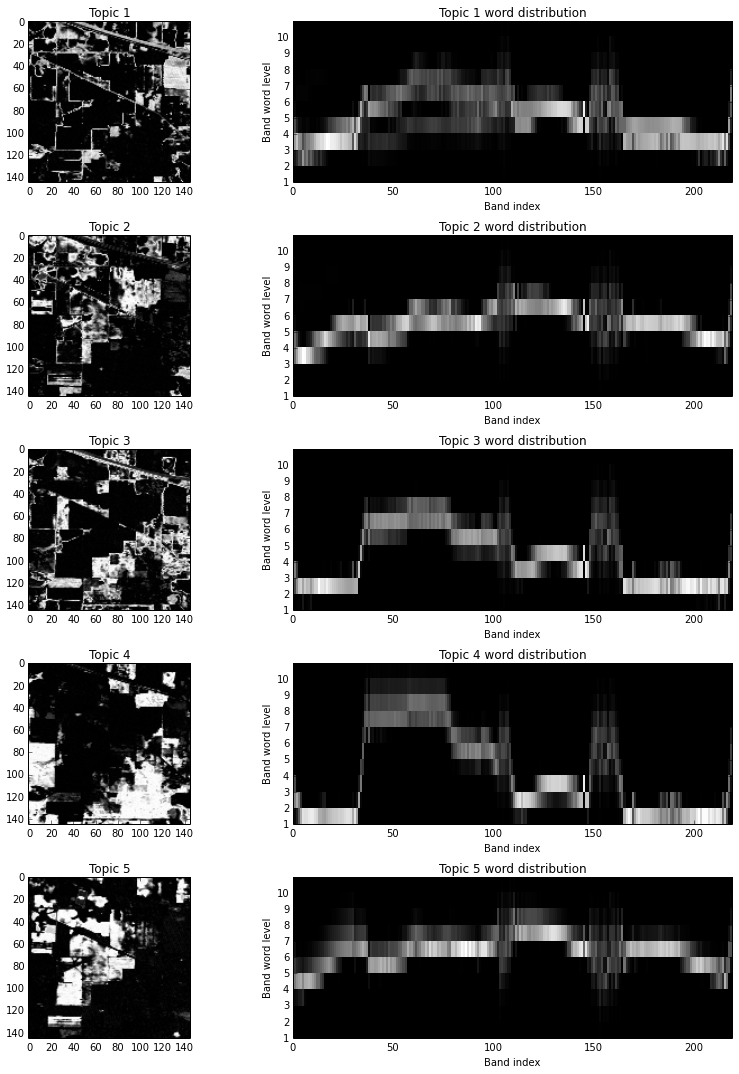

In [6]:
fig = plt.figure(figsize=(12, 3 *  ntopics))
for i in range(ntopics):
    plt.subplot(ntopics, 2, 2 * i + 1)
    spy.imshow(model.theta[i], fignum=fig.number, bounds=(0,1))
    plt.title('Topic ' + str(i + 1))
    plt.subplot(ntopics, 2, 2 * i + 2)
    model.show_topic_distribution(i)
    plt.title('Topic {} word distribution'.format(i + 1))
fig.tight_layout()

Brighter pixels in the topic images indicate a greater fraction of the associated topic in that pixel. For every image pixel, the topic fractions from the corresponding pixels in the 5 topic images always sum to unity. Qualitatively, the topic images above appear to separate gross categories of land-use classes reasonably well. I won't attempt to perform a thorough analysis of the results but there are a few obvious characteristics worth noting.

Topics 3 and 4 both appear to be associated with green vegetation in the RGB and ground truth images. Notice in the associated topic-word distribution plots there is a sharp rise near band 30. This spectral characteristic is the [red edge](http://en.wikipedia.org/wiki/Red_edge) associated with green vegetation (due to the presence of chlorophyll). For comparison, let's create an image of the [Normalized Difference Vegetation Index](http://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index) (NDVI), which is a commonly used means of highlighting green vegetation in multi-band imagery.


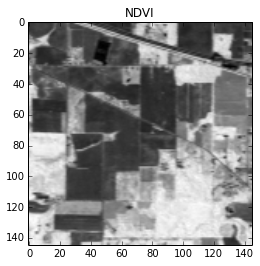

In [7]:
ndvi = spy.ndvi(image, 30, 50)
v = spy.imshow(ndvi)
plt.title('NDVI');

Brighter pixels in the NDVI image correspond to a more pronounced red edge. The bright regions in the NDVI appear to correspond to regions from both topic 3 and 4. Since the topic images represent fractional contributions of the topics to the total image content, we can easily add the images for topics 3 and 4 to see how the combination compares to the NDVI image.

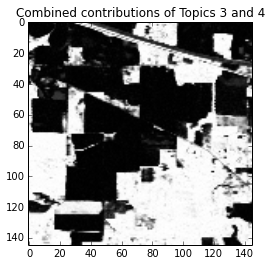

In [8]:
v = spy.imshow(model.theta[2] + model.theta[3], bounds=(0, 1))
plt.title('Combined contributions of Topics 3 and 4');

The combined image from topics 3 and 4 strongly resembles the NDVI image so we conclude that the LDA model has indeed learned two vegetation topics.

Next, we'll take the pixel with the highest NDVI and plot it in the normalized spectral feature space, along with the topic distribution for topic 4.

Maximum NDVI is at pixel (132, 103) with NDVI = [ 0.52224053]


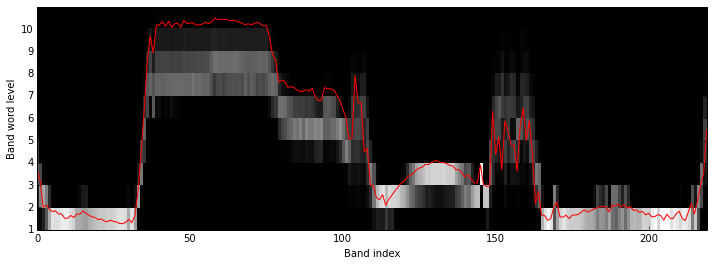

In [9]:
i = np.argmax(ndvi)
ncols = image.shape[1]
(r, c) = (i / ncols, i % ncols)
print 'Maximum NDVI is at pixel {} with NDVI = {}'.format((r, c), ndvi[r, c])
fig = plt.figure(figsize=(12, 4))
model.plot_normalized_spectrum(data[r, c], 'r-')
model.show_topic_distribution(3)

Overall, the vegetation spectrum folows the topic distribution fairly well. While it does appear to be significantly higher than the mean of the topic distribution between bands 40 and 100, this is not surprising since the topic represents a broad category of vegetation, whereas the vegetation spectrum plotted corresponds to the maximum NDVI in the image.

Next, we'll create a similar plot but this time we will plot the normalized spectrum of the image pixel containing the greatest fraction of topic 4.

Greatest fraction of Vegetation (topic 4) is at pixel (3, 80) with fraction 0.927659574468
NDVI at pixel (3, 80) = [ 0.4585495]


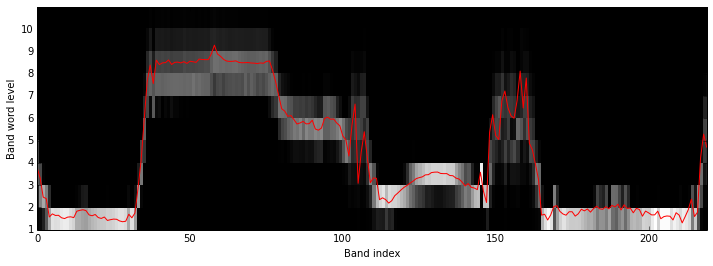

In [10]:
i = np.argmax(model.theta[3])
ncols = image.shape[1]
(r, c) = (i / ncols, i % ncols)
print 'Greatest fraction of Vegetation (topic 4) is at pixel {} with fraction {}'.format(
        (r, c), model.theta[r, c, 3])
print 'NDVI at pixel {} = {}'.format((r, c), ndvi[r, c])
fig = plt.figure(figsize=(12, 4))
model.plot_normalized_spectrum(data[r, c], 'r-')
model.show_topic_distribution(3)

This pixel, having a contribution of 93% from topic 4, maps very well to the topic-word distribution for the topic.

We won't go into detail on all three non-vegetation classes; however, note that the image for topic 1 appears to highlight the boundaries of regions in the image. These highlighted boundaries tend to be where topics 2 and 5 border topics 3 and 4. Two rather obvious hypotheses for this border topic are that (a) it represents some type of unique ground cover that lies between regions of other types of ground cover or (b) it represents mixed pixels (pixels containing both vegetation and the materials associated with classes 2 and 5).

Examining the topic-word distribution plot for topic 1, it does appear to have a less-pronounced red edge, indicating that there may be some fraction of vegetation associated with the topic (although less than in classes 3 and 4). Furthermore, notice that vertical profiles of the topic-word distribution between bands 40 and 80 appear to be multi-modal, suggesting that there are multiple material spectra associated with the distribution (i.e., a vegetation spectrum and a non-vegetation spectrum). Therefore, it is likely that topic 1 is associated with mixed pixels in regions of transition from classes 3 & 4 to 2 & 5.

## Image Classification from LDA Parameters

To perform an unsupervised classification of the image, we will again take a simple approach by assigning each pixel to a class associated with a particular LDA topic. We will do this simply by assigning each pixel to the topic having the greatest fractional abundance.

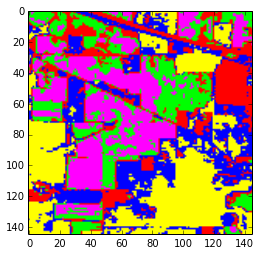

In [11]:
lda_classes = np.argmax(model.theta, axis=0) + 1
v = spy.imshow(classes=lda_classes)

For comparison, we will perform a [k-means](http://en.wikipedia.org/wiki/K-means) classification of the image using the same number of classes as topics in the LDA model. To simplify visual comparison, we will view the two classification images next to the ground truth image and mask out all unlabeled pixels.

Initializing clusters along diagonal of N-dimensional bounding box.
kmeans terminated with 5 clusters after 38 iterations.


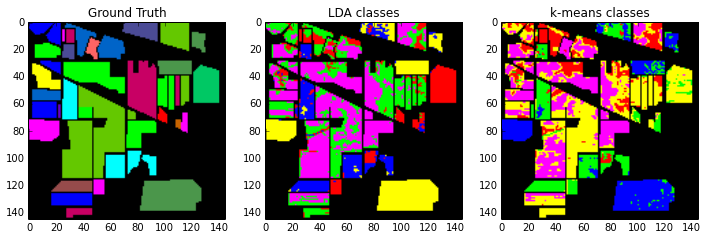

In [12]:
(kmeans_classes, c) = spy.kmeans(data, nclusters=ntopics, max_iterations=100)
kmeans_classes += 1

fig = plt.figure(figsize=(12,6))
p = plt.subplot(1, 3, 1)
v = spy.imshow(classes=gt, fignum=fig.number)
p.set_title('Ground Truth')
p = plt.subplot(1, 3, 2)
spy.imshow(classes=lda_classes * (gt != 0), fignum=fig.number)
p.set_title('LDA classes')
p = plt.subplot(1, 3, 3)
v = spy.imshow(classes=kmeans_classes * (gt != 0), fignum=fig.number)
p.set_title('k-means classes');

Note that in the images above, colors do not refer to common classes *between* images (e.g., blue pixels in the first image do not necessarily correspond to blue pixels in the other two images). Also, recall that the ground truth image labels 16 land-use classes, whereas the LDA and k-means images categorize pixels into only 5 classes.

There is surprisingly good agreement between the LDA and k-means images. Consider also that the k-means solution is not unique (the final clusters are dependent on how cluster means are initialized). In some regions, LDA provides a more homogeneous classification over the ground truth classes and in some others, k-means regions are more homogeneous. There are numerous regions that both LDA and k-means classify as inhomogeneous, which emphasises the point that the ground truth image labels regions of land *use*, whereas LDA and k-means label pixels based on spectral similarity.

The classification above used only 5 classes, which is significantly lower than the 16 land-use classes labeled in the ground truth image. So let's perform the same comparison with a larger number of classes. Considering that there may be some additional classes in the unlabeled regions of the ground truth image, we will use 20 topics/classes for the next comparison.

Initializing clusters along diagonal of N-dimensional bounding box.
kmeans terminated with 17 clusters after 69 iterations.


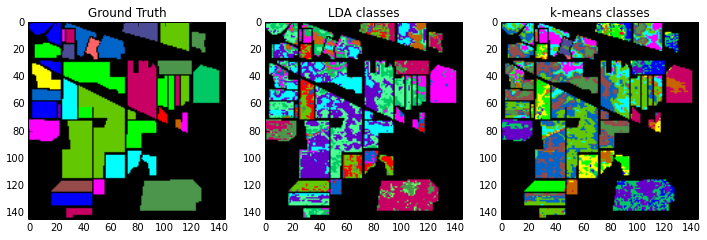

In [13]:
ntopics=20
model20 = QuantizedReflectanceLDAModel(nlevels)
lda = LDA(ntopics, niters, alpha, eta)
ret = lda.fit_transform(model20.corpus)
model20.get_results(lda)
lda_classes = np.argmax(model20.theta, axis=0) + 1

(kmeans_classes, c) = spy.kmeans(data, nclusters=ntopics, max_iterations=100)
kmeans_classes += 1

fig = plt.figure(figsize=(12,6))
p = plt.subplot(1, 3, 1)
v = spy.imshow(classes=gt, fignum=fig.number)
p.set_title('Ground Truth')
p = plt.subplot(1, 3, 2)
spy.imshow(classes=lda_classes * (gt != 0), fignum=fig.number)
p.set_title('LDA classes')
p = plt.subplot(1, 3, 3)
v = spy.imshow(classes=kmeans_classes * (gt != 0), fignum=fig.number)
p.set_title('k-means classes');

Even though 20 classes were specified to the k-means algorithm, only 17 classes remained when the algorithm completed (3 were consumed by other classes). The two algorithms compare very similarly to the previous case of 5 classes, although one might argue that LDA tended to produce more homogeneous regions in this comparison (even with 20 classes instead of only 17).

## Summary

The examples above show that Latent Dirichlet Allocation (LDA) is capable of extracting spectral topics at multiple levels of granularity. For realistic numbers of classes, LDA produces classes comparable to the commonly-used k-means algorithm. While LDA requires significantly longer computation time than k-means (up to several orders of magnitude, depending on the implementation), it also provides fractional abundances of learned classes/topics. Furthermore, LDA provides distributions of the spectral features for each topic learned, which can provide insight into the nature of the spectral topics learned.

## References

[1] Landgrebe, D. Multispectral data analysis: A signal theory perspective., School of Electr. Comput. Eng., Purdue Univ., West Lafayette, IN (1998).
